# Data Exploration and Notes for ShiftyLines

Figuring out how X-ray spectra work.

## Imports

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd 

from astropy.io import fits

## Data

The data files I currently have:
* `8525_nodip_0.dat`: *unfolded* data from Cygnus X-1; i.e. this is data with the response applied to the **data** (to use for figuring out whether the method works, not for actual data analysis)
    - X_LO: lower bound to the energy bin edge
    - X_HI: upper bound to the energy bin edge
    - DATA_VALUE: the unfolded flux in this energy bin
    - DATA_ERROR: estimate of the uncertainty of flux measurement
* `8525_nodip_cut.txt`: A cut version of the above data file with just a small segment of the data where we believe only a single Doppler shift to be present; same columns as file above.
* `8525_nodip_full.txt`: Same as first data file above, but without the text at the beginning
* `heg_m1.pha`, `heg_p1.pha`: High-energy grating spectra; not sure what the difference between `p1` and `m1` is ...
* `meg_m1.pha`, `meg_p1.pha`: mid-energy grating spectra; same question as above.
* `heg_m1.arf`, `heg_p1.arf`, `meg_m1.arf`, `meg_p1.arf`: anxilliary response files for the spectra (instrument response)
* `heg_m1.rmf`, `heg_p1.rmf`, `meg_m1.rmf`, `meg_p1.rmf`: redistribution matrix files for the spectra (instrument response)

Other files:
* `si_lines.txt`: List of silicon lines we're interested in.
* `lines_extended.txt`: Extended list of lines for future analysis.

### Looking at the unfolded spectra

Let's look at the unfolded data sets (where we've applied the *response* to the *data*). Generally, we'd like to apply the response to the model rather than the data, but looking at the unfolded spectra can be instructive:

In [2]:
names = ["bin_lo", "bin_hi", "counts", "counts_err"]
data = pd.read_csv("../data/8525_nodip_0.dat", sep="  ", 
                   names=names, comment="#")

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


In [3]:
data.head()

,bin_lo,bin_hi,counts,counts_err
0,6.0500,6.0525,0.101243,0.008145
1,6.0525,6.0550,0.096116,0.008029
2,6.0550,6.0575,0.095509,0.007942
3,6.0575,6.0600,0.096080,0.007962
4,6.0600,6.0625,0.114180,0.008602


In [4]:
names = ["bin_lo", "bin_hi", "counts", "counts_err"]
data_small = pd.read_csv("../data/8525_nodip_cut.txt", sep=" ", 
                   names=names, comment="#")

In [5]:
data_small.head()

,bin_lo,bin_hi,counts,counts_err
0,6.0500,6.0525,0.101243,0.008145
1,6.0525,6.0550,0.096116,0.008029
2,6.0550,6.0575,0.095509,0.007942
3,6.0575,6.0600,0.096080,0.007962
4,6.0600,6.0625,0.114180,0.008602


What's the fake data we've been trying stuff out on? 

In [6]:
fake_data = pd.read_csv("../data/test_noshift1.txt", sep=" ", names=names, comment="#")

In [7]:
fake_data.tail()

,bin_lo,bin_hi,counts,counts_err
415,7.0875,7.0900,0.097492,0.007
416,7.0900,7.0925,0.084984,0.007
417,7.0925,7.0950,0.101301,0.007
418,7.0950,7.0975,0.084311,0.007
419,7.0975,7.1000,0.085836,0.007


What's the range of Angstrom I'm looking at for the whole spectrum?

In [8]:
print("lower bin edge: " + str(data["bin_lo"].min()))
print("upper bin edge: " + str(data["bin_hi"].max()))
print("Total width of spectrum: " + str(data["bin_hi"].max() - data["bin_lo"].min()))

lower bin edge: 6.04999975757
upper bin edge: 7.74749971786
Total width of spectrum: 1.69749996029


What about the restricted spectrum? We did this because the slightly larger spectrum has a few additional lines that are not silicon lines, and possibly at a different Doppler shift.

In [9]:
print("lower bin edge: " + str(data_small["bin_lo"].min()))
print("upper bin edge: " + str(data_small["bin_hi"].max()))
print("Total width of spectrum: " + str(data_small["bin_hi"].max() - data_small["bin_lo"].min()))

lower bin edge: 6.04999975757
upper bin edge: 7.10000009779
Total width of spectrum: 1.05000034021


That's not much smaller, but a little bit. Before we plot both, let's make another column with the bin centre:

In [10]:
data["bin_mid"] = data["bin_lo"] + (data["bin_hi"]-data["bin_lo"])/2.0

In [11]:
data_small["bin_mid"] = data_small["bin_lo"] + (data_small["bin_hi"]-data_small["bin_lo"])/2.0

We also want to load the lines:

In [13]:
lines = np.loadtxt("../data/si_lines.txt")

<IPython.core.display.Javascript object>


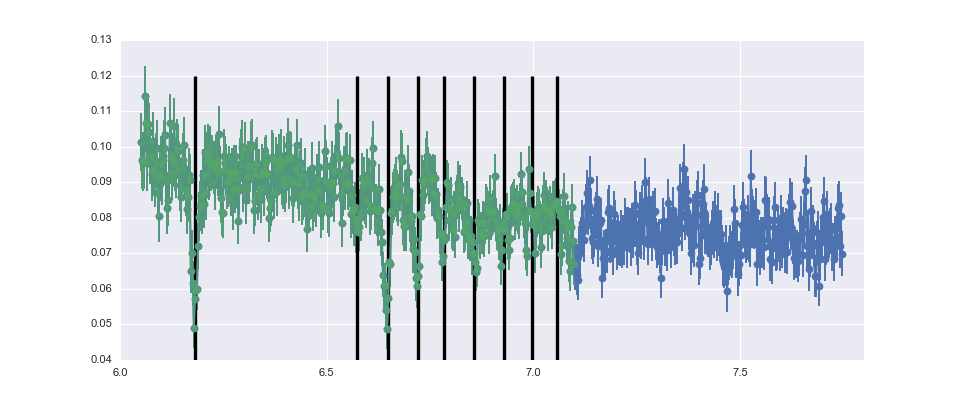

In [14]:
plt.figure(figsize=(12,5))
plt.errorbar(data["bin_mid"], data["counts"], yerr=data["counts_err"], fmt="o-")
plt.errorbar(data_small["bin_mid"], data_small["counts"], 
             yerr=data_small["counts_err"], fmt="o-", alpha=0.7)

for l in lines:
    plt.vlines(l, 0.04, 0.12, lw=3, color="black")

Great! That looks not bad. Let's look at the grating spectra.

### Looking at the Grating spectra

We're going to have to use `sherpa` or `astropy` to look at the grating spectra, because response files and so on. Let's first explore the data structure using `astropy.io.fits`:

In [15]:
rmf = fits.open("../data/cyg_daniela/heg_m1.rmf")
rmf.info()

Filename: ../data/cyg_daniela/heg_m1.rmf
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      24   ()              
1    MATRIX      BinTableHDU    144   8192R x 6C   [E, E, I, PI(1), PI(1), PD(103)]   
2    EBOUNDS     BinTableHDU     47   8192R x 3C   [I, E, E]   


In [16]:
rmf_data = rmf[1]

In [17]:
rmf_data.columns

ColDefs(
    name = 'ENERG_LO'; format = 'E'; unit = 'keV'
    name = 'ENERG_HI'; format = 'E'; unit = 'keV'
    name = 'N_GRP'; format = 'I'
    name = 'F_CHAN'; format = 'PI(1)'
    name = 'N_CHAN'; format = 'PI(1)'
    name = 'MATRIX'; format = 'PD(103)'
)

In [18]:
import sherpa.astro.ui

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [19]:
sherpa.astro.ui.load_data(id="heg_p1", filename="../data/cyg_daniela/heg_p1.pha")
sherpa.astro.ui.load_data(id="heg_m1", filename="../data/cyg_daniela/heg_m1.pha")
sherpa.astro.ui.load_data(id="meg_p1", filename="../data/cyg_daniela/meg_p1.pha")
sherpa.astro.ui.load_data(id="meg_m1", filename="../data/cyg_daniela/meg_m1.pha")

read ARF file ../data/cyg_daniela/heg_p1.arf
read RMF file ../data/cyg_daniela/heg_p1.rmf
read ARF file ../data/cyg_daniela/heg_m1.arf
read RMF file ../data/cyg_daniela/heg_m1.rmf
read ARF file ../data/cyg_daniela/meg_p1.arf
read RMF file ../data/cyg_daniela/meg_p1.rmf
read ARF file ../data/cyg_daniela/meg_m1.arf
read RMF file ../data/cyg_daniela/meg_m1.rmf


In [20]:
d_hp1 = sherpa.astro.ui.get_data("heg_p1")
d_hm1 = sherpa.astro.ui.get_data("heg_m1")

d_mp1 = sherpa.astro.ui.get_data("meg_p1")
d_mm1 = sherpa.astro.ui.get_data("meg_m1")

<IPython.core.display.Javascript object>


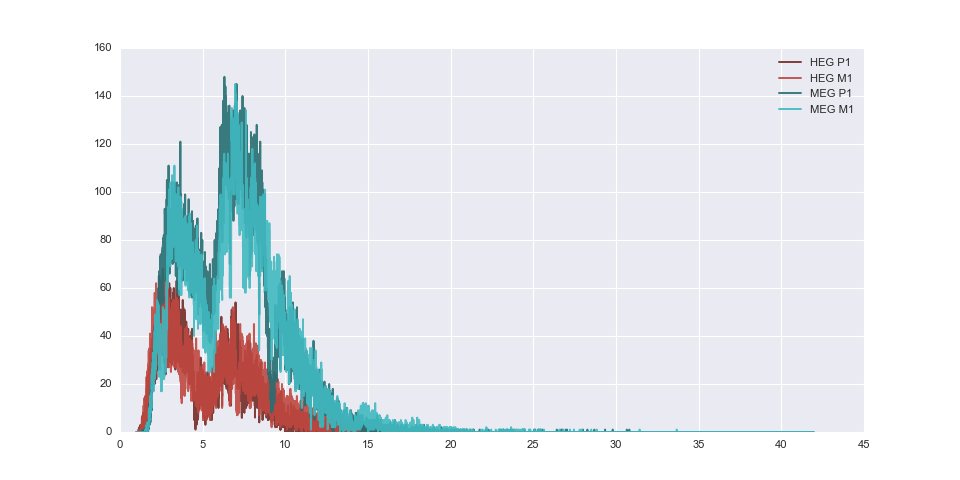

In [21]:
plt.figure(figsize=(12,6))
plt.plot(d_hp1.bin_lo, d_hp1.counts, label="HEG P1", alpha=0.9,
         c=sns.hls_palette(8, l=.3, s=.5)[0], linestyle="steps-mid")
plt.plot(d_hm1.bin_lo, d_hm1.counts, label="HEG M1", alpha=0.9,
         c=sns.hls_palette(8, l=.5, s=.5)[0], linestyle="steps-mid")
plt.plot(d_mp1.bin_lo, d_mp1.counts, label="MEG P1", alpha=0.9,
         c=sns.hls_palette(8, l=.3, s=.5)[4], linestyle="steps-mid")
plt.plot(d_mm1.bin_lo, d_mm1.counts, label="MEG M1", alpha=0.9,
         c=sns.hls_palette(8, l=.5, s=.5)[4], linestyle="steps-mid")
plt.legend()

We are going to cut out the part that has the lines:

In [22]:
d_idx_heg = d_hp1.bin_lo.argsort()

d_idx_meg = d_mp1.bin_lo.argsort()

In [23]:
bls_hp1 = d_hp1.bin_lo[d_idx_heg]
bhs_hp1 = d_hp1.bin_hi[d_idx_heg]
cs_hp1 = d_hp1.counts[d_idx_heg]

bls_hm1 = d_hm1.bin_lo[d_idx_heg]
bhs_hm1 = d_hm1.bin_hi[d_idx_heg]
cs_hm1 = d_hm1.counts[d_idx_heg]

bls_mp1 = d_mp1.bin_lo[d_idx_meg]
bhs_mp1 = d_mp1.bin_hi[d_idx_meg]
cs_mp1 = d_mp1.counts[d_idx_meg]

bls_mm1 = d_mm1.bin_lo[d_idx_meg]
bhs_mm1 = d_mm1.bin_hi[d_idx_meg]
cs_mm1 = d_mm1.counts[d_idx_meg]

In [24]:
min_idx_heg = bls_hp1.searchsorted(data_small["bin_lo"].min())
max_idx_heg = bhs_hp1.searchsorted(data_small["bin_hi"].max())

min_idx_meg = bls_mp1.searchsorted(data_small["bin_lo"].min())
max_idx_meg = bhs_mp1.searchsorted(data_small["bin_hi"].max())

In [25]:
bls_hp1_small = bls_hp1[min_idx_heg:max_idx_heg]
cs_hp1_small = cs_hp1[min_idx_heg:max_idx_heg]

bls_hm1_small = bls_hm1[min_idx_heg:max_idx_heg]
cs_hm1_small = cs_hm1[min_idx_heg:max_idx_heg]

bls_mp1_small = bls_mp1[min_idx_meg:max_idx_meg]
cs_mp1_small = cs_mp1[min_idx_meg:max_idx_meg]

bls_mm1_small = bls_mm1[min_idx_meg:max_idx_meg]
cs_mm1_small = cs_mm1[min_idx_meg:max_idx_meg]

Now let's plot only the part that we're currently interested in modelling:

<IPython.core.display.Javascript object>


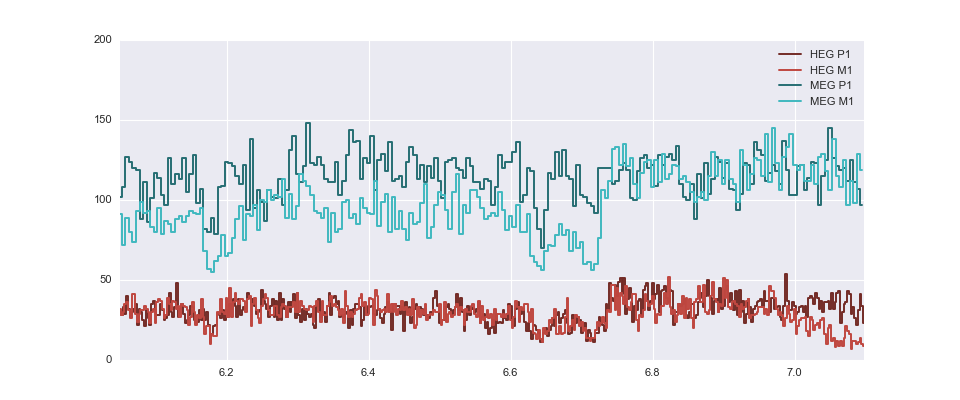

(0, 200)

In [26]:
plt.figure(figsize=(12,5))
plt.plot(bls_hp1_small, cs_hp1_small, c=sns.hls_palette(8, l=.3, s=.5)[0],
         linestyle="steps-mid", label="HEG P1")
plt.plot(bls_hm1_small, cs_hm1_small, c=sns.hls_palette(8, l=.5, s=.5)[0],
        linestyle="steps-mid", label="HEG M1")
plt.plot(bls_mp1_small, cs_mp1_small, c=sns.hls_palette(8, l=.3, s=.5)[4],
        linestyle="steps-mid", label="MEG P1")
plt.plot(bls_mm1_small, cs_mm1_small, c=sns.hls_palette(8, l=.5, s=.5)[4],
        linestyle="steps-mid", label="MEG M1")

plt.xlim(bls_hp1_small[0], bls_hp1_small[-1])
plt.legend()
plt.ylim(0, 200)

How many bins are there in the HEG spectra?

In [27]:
len(d_hp1.bin_lo)

8192

How many bins are there in the MEG spectra?

In [28]:
len(d_mp1.bin_lo)

8192

How many data points are there in the small spectra?

In [29]:
len(bls_hp1_small)

420

In [30]:
len(bls_mp1_small)

210

## Loading Posterior Samples

Let's start with just loading `samples.txt`, because this code is slow, so we'll prototype there.

In [31]:
#samples = np.loadtxt("../data/cyg_daniela/heg_p1.pha_posterior_sample.txt")
samples = np.loadtxt("../data/cyg_daniela/posterior_sample.txt")

In [32]:
print("There are %i posterior samples."%samples.shape[0])

There are 12 posterior samples.


We also want the line positions:

In [33]:
lines = np.loadtxt("../data/si_lines.txt")

In [34]:
lines

array([ 6.574     ,  6.64794778,  6.18222707,  6.71993761,  6.78432364,
        6.85605389,  6.92815553,  6.99681113,  7.05787013])

Now we're going to have to remember what the different parameters are:
* 0: background parameter
* 1: scaling for HEG M1 spectrum
* 2: scaling for MEG P1 spectrum
* 3: scaling for MEG M1 spectrum
* 4: OU time scale
* 5: OU amplitude
* 6: total number of parameters in model
* 7: number of possible Doppler shifts
* 8: log-amplitude hyper mean
* 9: log-amplitude hyper sigma
* 10: width hyper mean
* 11: width hyper sigma
* 12: threshold parameter
* 13: number of Doppler shifts
* 14,15,16,17: Doppler shift
* 18-XX: parameters for the lines, one per Doppler shift and per line
* XX-end: posterior sample spectrum

<IPython.core.display.Javascript object>


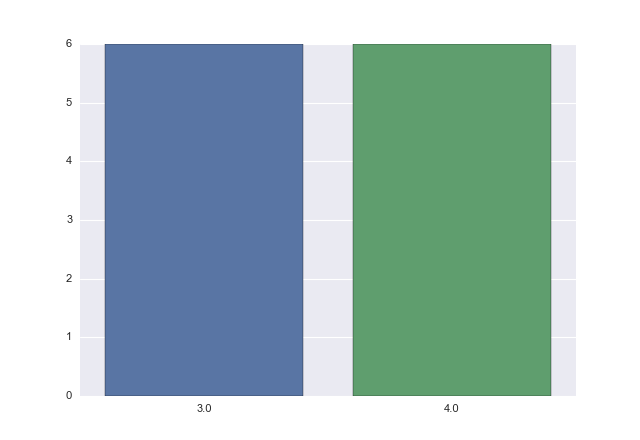

4.0    6
3.0    6
dtype: int64


In [35]:
plt.figure()
s = pd.Series(samples[-50:, 13]).value_counts()
print(s)
sns.barplot(s.index, s.values )

<IPython.core.display.Javascript object>


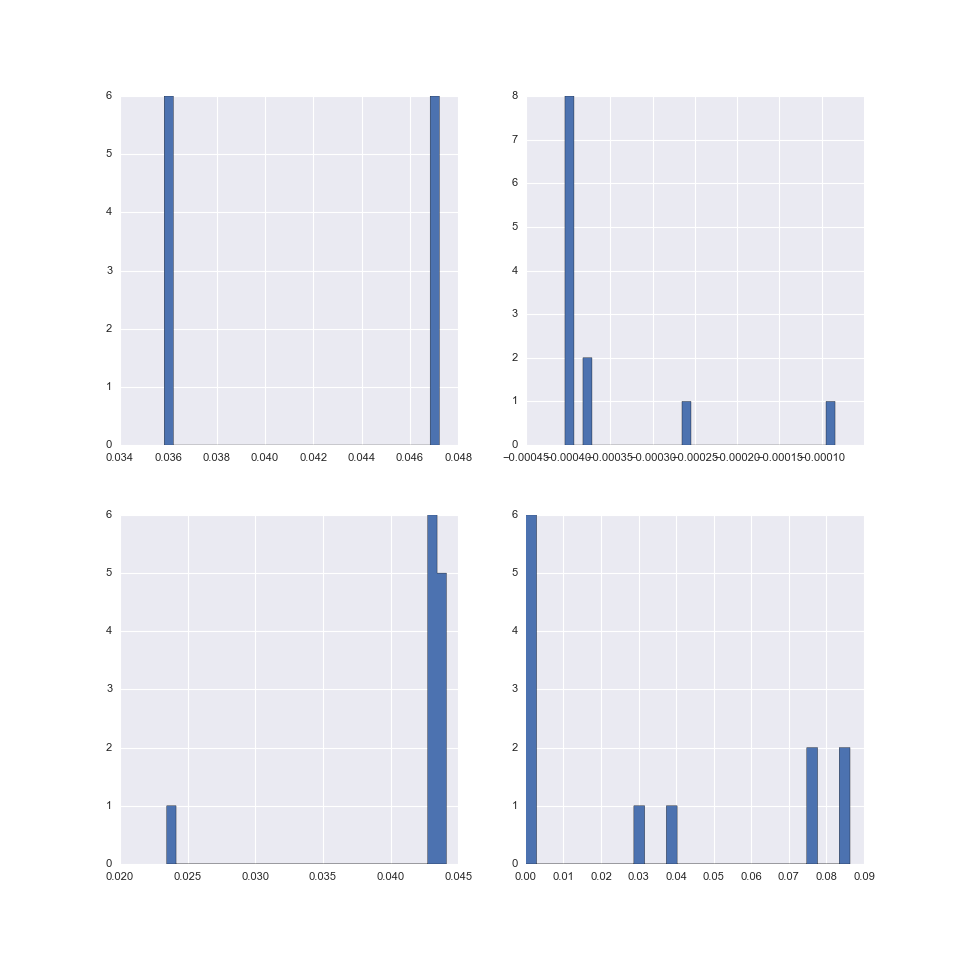

(array([ 6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         2.,  0.,  0.,  2.]),
 array([ 0.        ,  0.00287589,  0.00575177,  0.00862766,  0.01150355,
         0.01437943,  0.01725532,  0.02013121,  0.02300709,  0.02588298,
         0.02875887,  0.03163475,  0.03451064,  0.03738653,  0.04026241,
         0.0431383 ,  0.04601419,  0.04889007,  0.05176596,  0.05464185,
         0.05751773,  0.06039362,  0.06326951,  0.06614539,  0.06902128,
         0.07189717,  0.07477305,  0.07764894,  0.08052483,  0.08340071,
         0.0862766 ]),
 <a list of 1 Patch objects>)

In [36]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))
ax1.hist(samples[:,14], bins=30, histtype="stepfilled")
ax2.hist(samples[:,15], bins=30, histtype="stepfilled")
ax3.hist(samples[:,16], bins=30, histtype="stepfilled")
ax4.hist(samples[:,17], bins=30, histtype="stepfilled")


In [39]:
lines_shifted = lines*(1.0 + 0.036)

In [37]:
bls_hp1_small.shape

(420,)

<IPython.core.display.Javascript object>


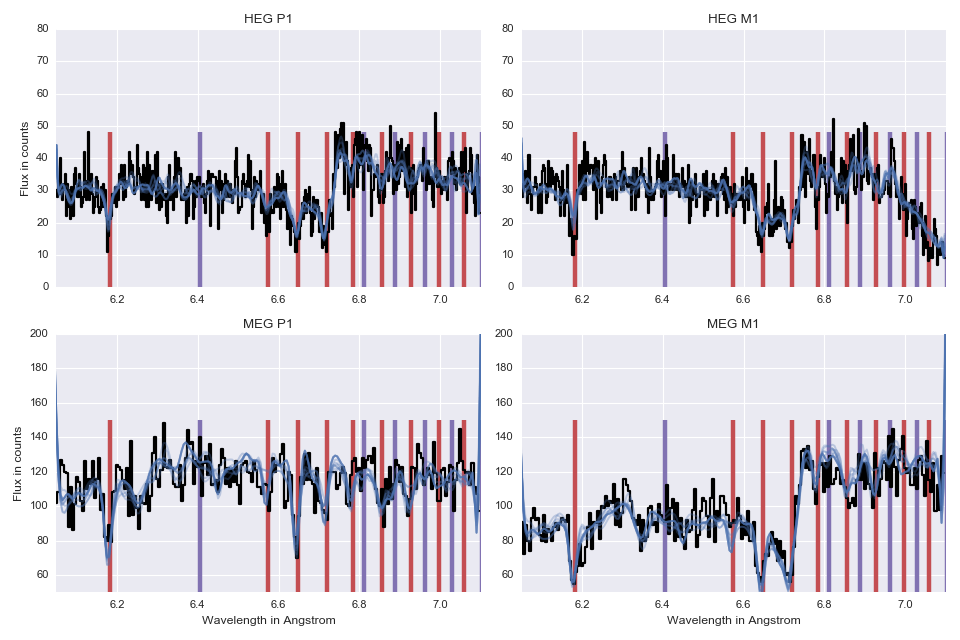

In [40]:
# make a figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))

# plot the data
ax1.plot(bls_hp1_small, cs_hp1_small, color="black", lw=2,
        linestyle="steps-mid")
ax2.plot(bls_hm1_small, cs_hm1_small, color="black", lw=2,
        linestyle="steps-mid")

ax3.plot(bls_mp1_small, cs_mp1_small, color="black", lw=2,
        linestyle="steps-mid")
ax4.plot(bls_mm1_small, cs_mm1_small, color="black", lw=2,
        linestyle="steps-mid")


# get edges for the plot
x_min = fake_data["bin_lo"].min()
x_max = fake_data["bin_hi"].max()

y_min = 0.0
y_max = 60.0
nmodels= len(bls_hp1)+len(bls_hm1)

for s in samples[-100:]:

    mhp = s[-(len(bls_hp1)+len(bls_hm1)+len(bls_mp1)+len(bls_mm1)):-(len(bls_hm1)+len(bls_mp1)+len(bls_mm1))]
    mhm = s[-(len(bls_hm1)+len(bls_mp1)+len(bls_mm1)):-(len(bls_mp1)+len(bls_mm1))]
    mmp = s[-(len(bls_mp1)+len(bls_mm1)):-len(bls_mm1)]
    mmm = s[-len(bls_mm1):]


    m_hpsort = mhp[d_idx_heg]
    m_hmsort = mhm[d_idx_heg]
    m_mpsort = mmp[d_idx_meg]
    m_mmsort = mmm[d_idx_meg]

    mhp_small = m_hpsort[min_idx_heg:max_idx_heg]
    mhm_small = m_hmsort[min_idx_heg:max_idx_heg]
    mmp_small = m_mpsort[min_idx_meg:max_idx_meg]
    mmm_small = m_mmsort[min_idx_meg:max_idx_meg]
    
    ax1.plot(bls_hp1_small, mhp_small, c=sns.color_palette()[0], alpha=0.3)
    ax2.plot(bls_hm1_small, mhm_small, c=sns.color_palette()[0], alpha=0.3)
    ax3.plot(bls_mp1, m_mpsort, c=sns.color_palette()[0], alpha=0.3)
    ax4.plot(bls_mm1, m_mmsort, c=sns.color_palette()[0], alpha=0.3)
    
    ax1.set_ylim(y_min, y_max)
    ax2.set_ylim(y_min, y_max)
    ax3.set_ylim(y_min, y_max)
    ax4.set_ylim(y_min, y_max)
    
    ax1.set_xlim(x_min, x_max)
    ax2.set_xlim(x_min, x_max)
    ax3.set_xlim(x_min, x_max)
    ax4.set_xlim(x_min, x_max)


#ax1.set_xlabel("Wavelength in Angstrom")
#ax2.set_xlabel("Wavelength in Angstrom")
ax3.set_xlabel("Wavelength in Angstrom")
ax4.set_xlabel("Wavelength in Angstrom")

ax1.set_ylabel("Flux in counts")
ax3.set_ylabel("Flux in counts")

for l in lines:
    ax1.vlines(l, y_min, 0.8*y_max, lw=4, color=sns.color_palette()[2])
    ax2.vlines(l, y_min, 0.8*y_max, lw=4, color=sns.color_palette()[2])
    ax3.vlines(l, 50, 150, lw=4, color=sns.color_palette()[2])
    ax4.vlines(l, 50, 150, lw=4, color=sns.color_palette()[2])


for l in lines_shifted:
    ax1.vlines(l, y_min, 0.8*y_max, lw=4, color=sns.color_palette()[3])
    ax2.vlines(l, y_min, 0.8*y_max, lw=4, color=sns.color_palette()[3])
    ax3.vlines(l, 50, 150, lw=4, color=sns.color_palette()[3])
    ax4.vlines(l, 50, 150, lw=4, color=sns.color_palette()[3])


ax1.set_ylim(0, 80)
ax2.set_ylim(0, 80)
ax3.set_ylim(50, 200)
ax4.set_ylim(50, 200)

ax1.set_title("HEG P1")
ax2.set_title("HEG M1")
ax3.set_title("MEG P1")
ax4.set_title("MEG M1")
plt.tight_layout()